<a href="https://colab.research.google.com/github/kavyajeetbora/CityHealthMonitor/blob/master/development/built-up-index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import external packages

In [1]:
!pip install -q rioxarray
!pip install -q h3
!pip install -q pydeck

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 43.2 MB/s eta 0:00:00


In [2]:
import geemap
import ee
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import Polygon, Point
import h3
from matplotlib import colormaps
import pydeck as pdk
import json
from tqdm import tqdm

ee.Authenticate()
ee.Initialize(project='kavyajeetbora-ee')

## Download the Data

- area of interest
- World Population Estimate dataset from google earth engine

In [3]:
!wget https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg -O gurgaon.gpkg

--2024-05-15 05:23:57--  https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg [following]
--2024-05-15 05:23:58--  https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98304 (96K) [application/octet-stream]
Saving to: ‘gurgaon.gpkg’

gurgaon.gpkg        100%[===================>]  96.00K  --.-KB/s    in 0.05s   

2024-05-15 05:23:59 (1.88 MB/s) - 

## Extract area of interest

In [4]:
gurgaon_gdf = gpd.read_file('gurgaon.gpkg', crs='EPSG:4326')
geojson = eval(gurgaon_gdf.to_json())

## Convert the geopackage file to ee.Geometry
featureCollection = ee.FeatureCollection(geojson)
ee_geometry = featureCollection.geometry()

## Get the raster data

In this example we will create a map for urban built-up index

For that we require images from the sentinel satellite

In [31]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

def calculate_indices(image):
    '''
    Calculate the NDVI, NDWI and NDBI for given image and add them to the bands
    '''
    ndvi = image.normalizedDifference(['B8','B4']).rename("NDVI")
    ndwi = image.normalizedDifference(['B8','B11']).rename('NDWI')
    ndbi = image.normalizedDifference(['B11', 'B8']).rename("NDBI")

    return image.addBands(ndvi).addBands(ndwi).addBands(ndbi)

processed = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterDate('2023-01-01', '2024-01-01')\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
    .map(mask_s2_clouds)\
    .map(calculate_indices)

visualization = {
    'min': -1,
    'max': 1,
    'bands': ['NDBI'],
    'palette': ['#fee0d2','#fc9272','#de2d26']
}

processed_image = processed.mean().clip(ee_geometry).select(['NDVI','NDWI','NDBI'])

center = (gurgaon_gdf.centroid[0].y, gurgaon_gdf.centroid[0].x)
Map = geemap.Map(center=center, zoom=10)
Map.add_layer(processed_image, visualization, 'NDBI')
Map

Map(center=[28.437398083125167, 77.06463665845695], controls=(WidgetControl(options=['position', 'transparent_…

In [33]:
geemap.ee_export_image(
    processed_image,
    filename='built_up_index.tif',
    scale=100,
    file_per_band=False,
    region=ee_geometry,
)

Generating URL ...
Please wait ...
Data downloaded to /content/built_up_index.tif


## Polygon to cell using uber-h3

In [46]:
APERTURE_SIZE = 9

In [79]:
def get_h3_from_boundary(boundary, APERTURE_SIZE):
    h3_indices = h3.polyfill(boundary, res=APERTURE_SIZE, geo_json_conformant=True)
    df_index = pd.DataFrame(h3_indices, columns=['h3_index'])
    h3_indices = df_index.set_index('h3_index')
    return h3_indices

In [80]:
geojson = eval(gurgaon_gdf.to_json())
geometry = geojson['features'][0]['geometry']
h3_indices = get_h3_from_boundary(geometry, APERTURE_SIZE)
print(f"Total numeber of h3 indices: {h3_indices.shape[0]}")
h3_indices.head()

Total numeber of h3 indices: 1038


""
h3_index
893da118e67ffff
893da118bdbffff
893da11a843ffff
893da118c5bffff
893da11a813ffff


In [81]:
# Define a layer to display on a map
layer = pdk.Layer(
    "H3HexagonLayer",
    h3_indices.reset_index(),
    pickable=True,
    stroked=True,
    filled=True,
    extruded=False,
    get_hexagon='h3_index',
    get_fill_color=[143, 32, 45, 100],
    getLineWidth= 20,
    getLineColor = [143, 32, 45, 100]
)

boundary = pdk.Layer(
    "GeoJsonLayer",
    json.loads(gurgaon_gdf.to_json()),
    pickable=True,
    stroked=True,
    filled=False,
    extruded=False,
    get_line_color=[255, 32, 12],
    getLineWidth= 20,

)

# Set the viewport location
aoi = gurgaon_gdf['geometry'].iloc[0]
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer, boundary], initial_view_state=view_state, description='Legend')
r

<IPython.core.display.Javascript object>

{
  "description": "Legend",
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "h3_index": "893da118e67ffff"
        },
        {
          "h3_index": "893da118bdbffff"
        },
        {
          "h3_index": "893da11a843ffff"
        },
        {
          "h3_index": "893da118c5bffff"
        },
        {
          "h3_index": "893da11a813ffff"
        },
        {
          "h3_index": "893da118d33ffff"
        },
        {
          "h3_index": "893da11a9d7ffff"
        },
        {
          "h3_index": "893da118113ffff"
        },
        {
          "h3_index": "893da118053ffff"
        },
        {
          "h3_index": "893da111a57ffff"
        },
        {
          "h3_index": "893da10368bffff"
        },
        {
          "h3_index": "893da11ae6bffff"
        },
        {
          "h3_index": "893da111b57ffff"
        },
        {
          "h3_index": "893da11ac4fffff"
        },
        {
          "h3_index": "893da1184a7ffff"
        },
        {
          "h3_index": "893da118897ffff"
        },
        {
          "h3_index": "893da1185bbffff"
        },
        {
          "h3_index": "893da11888bffff"
        },
        {
          "h3_index": "893da11aa67ffff"
        },
        {
          "h3_index": "893da119db3ffff"
        },
        {
          "h3_index": "893da118d17ffff"
        },
        {
          "h3_index": "893da11843bffff"
        },
        {
          "h3_index": "893da118483ffff"
        },
        {
          "h3_index": "893da11a8bbffff"
        },
        {
          "h3_index": "893da11ada3ffff"
        },
        {
          "h3_index": "893da111a63ffff"
        },
        {
          "h3_index": "893da111e57ffff"
        },
        {
          "h3_index": "893da11a8c7ffff"
        },
        {
          "h3_index": "893da11807bffff"
        },
        {
          "h3_index": "893da11a8abffff"
        },
        {
          "h3_index": "893da11a82bffff"
        },
        {
          "h3_index": "893da111a7bffff"
        },
        {
          "h3_index": "893da11ad6fffff"
        },
        {
          "h3_index": "893da11a943ffff"
        },
        {
          "h3_index": "893da118143ffff"
        },
        {
          "h3_index": "893da11ac4bffff"
        },
        {
          "h3_index": "893da118e5bffff"
        },
        {
          "h3_index": "893da1184afffff"
        },
        {
          "h3_index": "893da11ad57ffff"
        },
        {
          "h3_index": "893da1180a3ffff"
        },
        {
          "h3_index": "893da11aacbffff"
        },
        {
          "h3_index": "893da118583ffff"
        },
        {
          "h3_index": "893da1034c3ffff"
        },
        {
          "h3_index": "893da119d03ffff"
        },
        {
          "h3_index": "893da118593ffff"
        },
        {
          "h3_index": "893da119dafffff"
        },
        {
          "h3_index": "893da11aa53ffff"
        },
        {
          "h3_index": "893da118c57ffff"
        },
        {
          "h3_index": "893da118307ffff"
        },
        {
          "h3_index": "893da11aa33ffff"
        },
        {
          "h3_index": "893da1034d7ffff"
        },
        {
          "h3_index": "893da111e23ffff"
        },
        {
          "h3_index": "893da10341bffff"
        },
        {
          "h3_index": "893da11832bffff"
        },
        {
          "h3_index": "893da118e63ffff"
        },
        {
          "h3_index": "893da111a4fffff"
        },
        {
          "h3_index": "893da11ae53ffff"
        },
        {
          "h3_index": "893da1184abffff"
        },
        {
          "h3_index": "893da11ad27ffff"
        },
        {
          "h3_index": "893da11818bffff"
        },
        {
          "h3_index": "893da11859bffff"
        },
        {
          "h3_index

## Converting the raster to xyz point data


In [82]:
def raster_to_xyz(xds, val_col, band_no):
    xds = rioxarray.open_rasterio(raster_file)\
            .sel(band=band_no)\
            .to_pandas()

    xds = xds.stack().reset_index().rename(columns={"x": 'lng', 'y': 'lat', 0: val_col})
    return xds

def convert_to_gdf(df, aoi):
    df['geometry'] = list(map(Point, zip(df['lng'], df['lat'])))
    gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry='geometry')

    ## Clip the geometry
    gdf = gdf[gdf['geometry'].within(aoi)]
    print(f"Total of {gdf.shape[0]} points are in the dataset")

    return gdf


def aggregate_gdf_by_h3(gdf, APERTURE_SIZE, agg='sum', val_col='population'):
    # find hex indices for all the points
    gdf['h3_index'] = gdf.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

    # calculate temperature average per hex
    hex_data = gdf.groupby('h3_index')[val_col].agg(agg).to_frame(val_col).reset_index()

    return hex_data

1. Convert raster to xyz points

In [85]:
raster_file = 'built_up_index.tif'
aoi = gurgaon_gdf.geometry.iloc[0]

bands = {
    1: 'NDVI',
    2: 'NDWI',
    3: 'NDBI'
}

raster_data = None
for i, (k,v) in enumerate(bands.items()):
    xds = raster_to_xyz(raster_file, val_col=v,band_no=k)
    gdf = convert_to_gdf(xds, aoi)
    df = aggregate_gdf_by_h3(gdf, APERTURE_SIZE, agg='mean', val_col=v)
    if i==0:
        raster_data = df
    else:
        raster_data = raster_data.merge(df, on='h3_index', how='left')

raster_data = h3_indices.reset_index().merge(raster_data, on='h3_index', how='left')
print(raster_data.shape)
raster_data.head()

Total of 12926 points are in the dataset
Total of 12926 points are in the dataset
Total of 12926 points are in the dataset
(1038, 4)


,h3_index,NDVI,NDWI,NDBI
0,893da118e67ffff,0.266855,-0.001780,0.001780
1,893da118bdbffff,0.417904,0.041836,-0.041836
2,893da11a843ffff,0.283364,0.065537,-0.065537
3,893da118c5bffff,0.179066,-0.034489,0.034489
4,893da11a813ffff,0.270860,0.030428,-0.030428


## Visualizing the results in pydeck

for visualizing the surface temperature data, we will first format the data


- Normalizing the temperature values
- then color coding the temperature values using a colormap
- splitting the colormap values to make it compatible with pydeck `get_fill_color` attribute
- Formatting a tooltip for interactive data visualization

In [108]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)
    return xdf

def create_h3_hex_layer(df,hex_col):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

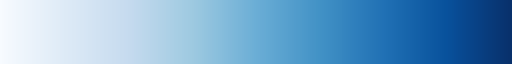

In [116]:
## Choose a colormap
cmap = colormaps['Blues']
cmap

Generating the tooltip:

## Finally plotting the results on a 3D map

In [117]:
## Apply the colormap to the dataframe
value_col='NDWI'

## Modify the tooltip
html = "<b>"+value_col+"</b>: {"+ value_col + "}"
tooltip = {
        "html": html,
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }


xdf = colormap_dataframe(df=raster_data, value_col=value_col, cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf, hex_col='h3_index')

# Set the viewport location
view_state = pdk.ViewState(latitude=aoi.centroid.y, longitude=aoi.centroid.x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip, description='Legend')
r

<IPython.core.display.Javascript object>

{
  "description": "Legend",
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 240,
          "G": 221,
          "NDBI": 0.0017803871305659413,
          "NDVI": 0.26685500144958496,
          "NDWI": -0.0017803871305659413,
          "R": 201,
          "h3_index": "893da118e67ffff"
        },
        {
          "A": 100,
          "B": 225,
          "G": 202,
          "NDBI": -0.04183634743094444,
          "NDVI": 0.4179043769836426,
          "NDWI": 0.04183634743094444,
          "R": 158,
          "h3_index": "893da118bdbffff"
        },
        {
          "A": 100,
          "B": 218,
          "G": 184,
          "NDBI": -0.0655372217297554,
          "NDVI": 0.28336384892463684,
          "NDWI": 0.0655372217297554,
          "R": 127,
          "h3_index": "893da11a843ffff"
        },
        {
          "A": 100,
          "B": 246,
          "G": 234,
          "NDBI": 0.03448854014277458,
          "NDVI": 0.1790662556886673,
          "NDWI": -0.03448854014277458,
          "R": 221,
          "h3_index": "893da118c5bffff"
        },
        {
          "A": 100,
          "B": 229,
          "G": 207,
          "NDBI": -0.030428271740674973,
          "NDVI": 0.2708595097064972,
          "NDWI": 0.030428271740674973,
          "R": 170,
          "h3_index": "893da11a813ffff"
        },
        {
          "A": 100,
          "B": 208,
          "G": 163,
          "NDBI": -0.09499833732843399,
          "NDVI": 0.38315632939338684,
          "NDWI": 0.09499833732843399,
          "R": 92,
          "h3_index": "893da118d33ffff"
        },
        {
          "A": 100,
          "B": 209,
          "G": 166,
          "NDBI": -0.09063035994768143,
          "NDVI": 0.33675044775009155,
          "NDWI": 0.09063035994768143,
          "R": 96,
          "h3_index": "893da11a9d7ffff"
        },
        {
          "A": 100,
          "B": 234,
          "G": 214,
          "NDBI": -0.014537491835653782,
          "NDVI": 0.23705849051475525,
          "NDWI": 0.014537491835653782,
          "R": 186,
          "h3_index": "893da118113ffff"
        },
        {
          "A": 100,
          "B": 234,
          "G": 213,
          "NDBI": -0.015912774950265884,
          "NDVI": 0.40950024127960205,
          "NDWI": 0.015912774950265884,
          "R": 185,
          "h3_index": "893da118053ffff"
        },
        {
          "A": 100,
          "B": 216,
          "G": 179,
          "NDBI": -0.07239241898059845,
          "NDVI": 0.293140709400177,
          "NDWI": 0.07239241898059845,
          "R": 117,
          "h3_index": "893da111a57ffff"
        },
        {
          "A": 100,
          "B": 229,
          "G": 207,
          "NDBI": -0.031167441979050636,
          "NDVI": 0.2564702332019806,
          "NDWI": 0.031167441979050636,
          "R": 170,
          "h3_index": "893da10368bffff"
        },
        {
          "A": 100,
          "B": 213,
          "G": 173,
          "NDBI": -0.08144358545541763,
          "NDVI": 0.3380158841609955,
          "NDWI": 0.08144358545541763,
          "R": 106,
          "h3_index": "893da11ae6bffff"
        },
        {
          "A": 100,
          "B": 238,
          "G": 218,
          "NDBI": -0.004642898682504892,
          "NDVI": 0.243338942527771,
          "NDWI": 0.004642898682504892,
          "R": 197,
          "h3_index": "893da111b57ffff"
        },
        {
          "A": 100,
          "B": 230,
          "G": 208,
          "NDBI": -0.027949946001172066,
          "NDVI": 0.2909652292728424,
          "NDWI": 0.027949946001172066,
          "R": 172,
          "h3_index": "893da11ac4fffff"
        },
        {
          "A": 100,
          "B": 241,
          "G": 223,
          "NDBI": 0.0062083168886601925,
          "

In [ ]:
import matplotlib as mpl
COLOR = 'blue'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

fig, ax = plt.subplots(figsize=(6, 1), layout='constrained')
norm = mpl.colors.Normalize(vmin=xdf['population'].min(), vmax=xdf['population'].max())
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Some Units')
fig.savefig('temp.png', transparent=True)

## Export the data


In [118]:
raster_data.to_parquet('raster_data.parquet')